In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp  
    
# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDownOnlyLast.py', '../models/Vanilla.py', '../models/SimplifierBottomUp1e-2.py', '../models/SimplifierBottomUp1e-4.py', '../models/SimplifierBottomUp1e-6.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierBottomUp1e-1.py', '../models/SimplifierBottomUp1e-0.py', '../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUp.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDown1e-6.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierBottomUp1e-10.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-0.py'] ['Top Down (only last)', 'Without simplify', 'Bottom Up 1e-2', 'Bottom Up 1e-4', 'Bottom Up 1e-6', 'Top Down 1e-2', 'Bottom Up 1e-1', 'Bottom Up 1e-0', 'Top Down 1e-1', 'Bottom Up', 'Top Down 1e-10', 'Bottom Up (only last)', 'Top Down 1e-6', 'Top Down 1e-4', 'Bottom Up 1e-10', 'Top Down', 'Top Down 1e-0']
(540, 14)
['Without simplify' 'Bottom Up' 'Top Dow

model
Bottom Up    9.16 \pm 42.70
Top Down     3.04 \pm 36.20
dtype: object

Bottom Up greater TtestResult(statistic=-1.1970618248922709, pvalue=0.8835673059262475, df=179)
Bottom Up less TtestResult(statistic=-1.1970618248922709, pvalue=0.11643269407375245, df=179)
Top Down greater TtestResult(statistic=-0.6867541912553516, pvalue=0.7534368255507617, df=179)
Top Down less TtestResult(statistic=-0.6867541912553516, pvalue=0.2465631744492382, df=179)


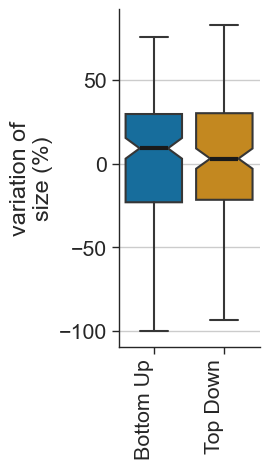

model
Bottom Up    -37.22 \pm 458.31
Top Down     -13.13 \pm 402.34
dtype: object

Bottom Up greater TtestResult(statistic=-4.480457807998934, pvalue=0.9999933740753665, df=179)
Bottom Up less TtestResult(statistic=-4.480457807998934, pvalue=6.625924633503376e-06, df=179)
Top Down greater TtestResult(statistic=-5.018977710115804, pvalue=0.9999993764560009, df=179)
Top Down less TtestResult(statistic=-5.018977710115804, pvalue=6.235439990649053e-07, df=179)


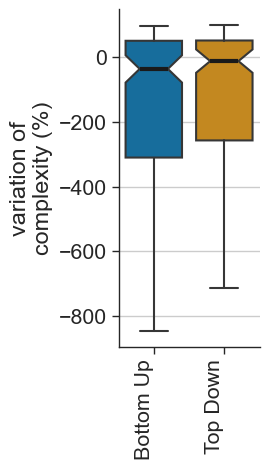

model
Bottom Up    1.78 \pm 4111683.95
Top Down         1.01 \pm 174.49
dtype: object

Bottom Up greater TtestResult(statistic=-0.9999449783282606, pvalue=0.8406565181598754, df=179)
Bottom Up less TtestResult(statistic=-0.9999449783282606, pvalue=0.15934348184012456, df=179)
Top Down greater TtestResult(statistic=0.7408939661685148, pvalue=0.2298642720522972, df=179)
Top Down less TtestResult(statistic=0.7408939661685148, pvalue=0.7701357279477028, df=179)


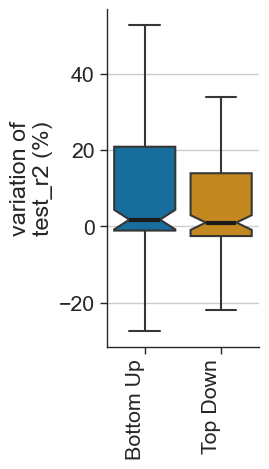

model
Bottom Up    -14.47 \pm 313.26
Top Down     -11.94 \pm 533.93
dtype: object

Bottom Up greater TtestResult(statistic=-2.251171446759097, pvalue=0.987204574576659, df=179)
Bottom Up less TtestResult(statistic=-2.251171446759097, pvalue=0.01279542542334102, df=179)
Top Down greater TtestResult(statistic=-1.8856982747835729, pvalue=0.9695222589113179, df=179)
Top Down less TtestResult(statistic=-1.8856982747835729, pvalue=0.030477741088682002, df=179)


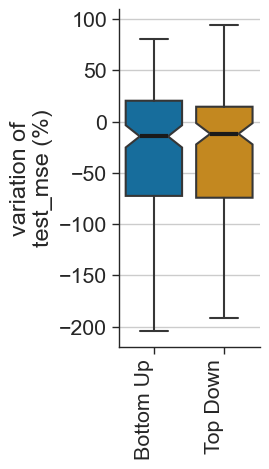

In [2]:
baseline_convergence = (results_df.loc[results_df['model'] == 'Without simplify'].groupby(['dataset', 'random_state']))

for metric in ['size', 'complexity', 'test_r2', 'test_mse']:
    speeds    = []
    for (model, dataset, random_state), group_df in \
        results_df.loc[results_df['model'] != 'Without simplify'].groupby(['model', 'dataset', 'random_state']):
        # 'contextual' is used as a hue in the plots

        baseline_curve = baseline_convergence.get_group((dataset, random_state))
        
        metric_baseline = baseline_curve[metric].values[0]
        metric_model = group_df[metric].values[0]
        speeds.append( (model, dataset, (metric_model-metric_baseline)*100/metric_model) )

    speeds_df = pd.DataFrame(data=speeds, columns=['model', 'dataset', 'delta'])

    display(speeds_df.groupby(['model'])
            .agg(['median','mad'])
            .applymap(lambda x: '{0:.2f}'.format(x))
            .agg(r' \pm '.join, axis=1)
            )

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html
    for model in speeds_df['model'].unique():
        print(model, 'greater',
              ttest_1samp(
                  (speeds_df[speeds_df['model']==model])['delta'].dropna(),
                  popmean=0.0, alternative='greater'
              )
        )
        print(model, 'less',
              ttest_1samp(
                  (speeds_df[speeds_df['model']==model])['delta'].dropna(),
                  popmean=0.0, alternative='less'
              )
        )

    g=sns.catplot( data=speeds_df, y=f'delta', x='model', 
        #col='dataset', col_wrap=col_wrap, # remove col to aggregate all speed ups into one plot
        legend_out=False, aspect=0.6,
        order = [o for o in order if o != 'Without simplify'], # The first is Baseline
        **boxplot_kwargs, sharey=False
    )

    # g.set(yscale="log")

    g.set_titles("{col_name}").set_axis_labels("", f"variation of\n{metric} (%)")

    # iterate through each subplot / Facet
    single_plot = True
    for (ds, plot_ax) in g._axes_dict.items():
        single_plot = False
        plot_ax.grid(which='major', axis='y', linewidth=1)
        #plot_ax.axhline(100.0, c='k', zorder=-999, linewidth=1.5)
        
        for tick in plot_ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

        # Contextual vs non-contextual
        pairs = [('D-TS', 'C-D-TS'), ('D-UCB1', 'C-D-UCB1')]

        if False:
            annotator = Annotator(
                plot_ax, pairs, data=speeds_df[(speeds_df['dataset']==ds)],
                x='model', y='Speed up',
                order=order[1:])
            annotator.reset_configuration()
            annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
            
            # Calculate and annotate
            annotator.apply_and_annotate()
            
    if single_plot: 
        g.ax.grid(which='major', axis='y', linewidth=1)
        #g.ax.axhline(1.0, c='k', zorder=-999, linewidth=1.5)
        
        for tick in g.ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/delta_{metric}.pdf")
    plt.savefig(f"../paper/figs/delta_{metric}.png")
    plt.show()

In [3]:
print(sns.color_palette("colorblind").as_hex())
sns.color_palette("colorblind").as_hex()

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']